# Prepare NINO 3.4, DMI and SAM data from raw forecast/historical data and save intermediate files for further processing

### Time taken: ~ 30 mins

------

In [ ]:
import glob

import numpy as np
import xarray as xr

import myfuncs as my

from dask.distributed import Client
from dask_jobqueue import PBSCluster

import warnings
warnings.filterwarnings("ignore")

In [2]:
walltime = '02:00:00'
cores = 48
memory = '192GB'
cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),
                     job_extra=['-l ncpus='+str(cores),
                                '-l mem='+str(memory),
                                '-P v14',
                                '-l jobfs=100GB',
                                '-l storage=gdata/xv83+gdata/v14+scratch/v14'],
                     local_directory='$PBS_JOBFS',
                     # env_extra=['export MALLOC_TRIM_THRESHOLD_="0"'],
                     header_skip=["select"])

In [3]:
cluster.scale(jobs=1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: http://10.6.62.47:8787/status,
Dashboard: http://10.6.62.47:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.62.47:37287,Workers: 0
Dashboard: http://10.6.62.47:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


--------
# Parameters

In [2]:
period = slice('1990-01-01','2020-12-31')
SON = [9,10,11]
SOND = [9,10,11,12]

clobber = False # If False, read intermediate datasets from disk if they exist

--------
# Prepare historical NINO3.4 and DMI values from HadISST

In [3]:
data_path = '/g/data/xv83/reanalyses/HadISST'

had_sst = my.open_zarr(
    f'{data_path}/ocean_month.zarr', 
    variables=['sst'])['sst']

### Process SOND Nino3.4

In [4]:
had_nino34_full = my.calc_nino34(
    had_sst, lat_dim='latitude', lon_dim='longitude').rename('nino34')
had_nino34_full = had_nino34_full.chunk({'time': -1})
had_nino34_full = my.to_zarr(
    had_nino34_full, f'data/HadISST_Nino34-full.zarr', clobber=clobber)

had_nino34_SOND_full = my.resample_months_in_year(
    had_nino34_full, SOND, method='mean').rename('nino34_SOND')
had_nino34_SOND_clim = had_nino34_SOND_full.sel(
    time=period).groupby('time.month').mean('time')
had_nino34_SOND = had_nino34_SOND_full.groupby('time.month') - had_nino34_SOND_clim
had_nino34_SOND = my.to_zarr(
    had_nino34_SOND, f'data/HadISST_Nino34-SOND.zarr', clobber=clobber)

## Figure for reviewer: delete me

Mann_Kendall_Test(trend='no trend', h=False, p=0.8984338269926528, z=0.12764006014960397, Tau=0.002233676975945017, s=2366.0, var_s=343311451.3333333, slope=6.246841784983862e-06, intercept=-0.1685088489439859)


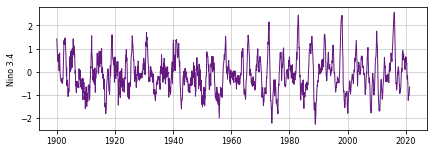

In [22]:
import pymannkendall as mk
import matplotlib.pyplot as plt
from matplotlib import cm

test_period=slice('1900',None)

had_nino34_clim = had_nino34_full.sel(
    time=period).groupby('time.month').mean('time')
had_nino34 = had_nino34_full.sel(time=test_period).groupby('time.month') - had_nino34_clim

ax_color = 'k'
fontsize = 8
rc_context = {'axes.edgecolor':ax_color, 
              'xtick.color':ax_color, 
              'ytick.color':ax_color,
              'axes.labelcolor': ax_color,
              'text.color': ax_color,
              'font.size': fontsize}

with plt.rc_context(rc_context):
    fig = plt.figure(constrained_layout=True, figsize=(5.9,2.0))

    col = cm.get_cmap('magma')(0.3)

    ax = fig.add_subplot(111)
    ax.grid(zorder=-1, linewidth=0.5)
    ax.plot(had_nino34.time, had_nino34, 
            linestyle='-', color=col, linewidth=1)

    ax.set_ylabel('Nino 3.4');
    
print(mk.original_test(had_nino34.values))
    
fig.savefig(f'./figures/nino34_record.pdf', format='pdf',
            bbox_inches='tight')

### Process SON DMI

In [11]:
had_dmi_full = my.calc_dmi(
    had_sst, lat_dim='latitude', lon_dim='longitude').rename('dmi')
had_dmi_full = had_dmi_full.chunk({'time': -1})
had_dmi_full = my.to_zarr(
    had_dmi_full, f'data/HadISST_DMI-full.zarr', clobber=clobber)

had_dmi_SON_full =  my.resample_months_in_year(
    had_dmi_full, SON, method='mean').rename('dmi_SON')
had_dmi_SON_clim = had_dmi_SON_full.sel(
    time=period).groupby('time.month').mean('time')
had_dmi_SON = had_dmi_SON_full.groupby('time.month') - had_dmi_SON_clim
had_dmi_SON = my.to_zarr(
    had_dmi_SON, f'data/HadISST_DMI-SON.zarr', clobber=clobber)

--------
# Prepare historical SOND SAM values from JRA-55

In [14]:
data_path = '/g/data/xv83/reanalyses/JRA55'

In [16]:
jra_slp = my.open_zarr(
    f'{data_path}/surface_month.zarr', 
    variables=['PRMSL_GDS0_MSL'],
    open_zarr_kwargs={'use_cftime': True}).rename(
    {'initial_time0_hours': 'time'})['PRMSL_GDS0_MSL']

jra_sam = my.calc_sam(
    jra_slp, period, lat_dim='g0_lat_1', lon_dim='g0_lon_2')
jra_sam = jra_sam.chunk({'time': -1})
jra_sam = my.to_zarr(
    jra_sam, f'data/JRA-55_SAM.zarr', clobber=clobber)

jra_sam_SOND = my.resample_months_in_year(
    jra_sam, SOND, method='mean').rename('sam_SOND')
jra_sam_SOND = my.to_zarr(
    jra_sam_SOND, f'data/JRA-55_SAM-SOND.zarr', clobber=clobber)

--------
# Prepare CAFE-f6 forecast data
Don't worry about masking members that were run with reduced timestep here
since only use these data conditioned on the FFDI and DI data, which have these members dropped already

### Process SON sst

In [3]:
def preprocess(ds):
    return ds.drop(['average_DT', 'average_T1', 'average_T2', 'geolat_t', 'geolon_t', 'area_t'])

fcst_paths = sorted(
    glob.glob('/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6*/ocean_month.zarr.zip')
)[-32:]

f6_ocean_stacked = my.open_zarr_forecasts(
    fcst_paths,
    variables=['sst'],
    convert_time_to_lead=True,
    preprocess=preprocess)

In [4]:
f6_sst_stacked = f6_ocean_stacked['sst']
f6_sst_stacked = my.to_zarr(
    f6_sst_stacked, f'data/CAFE-f6_sst-full-stacked.zarr', clobber=clobber)

f6_sst = my.reindex_forecast(f6_sst_stacked)
f6_sst_SON = my.resample_months_in_year(
    f6_sst, SON, method='mean').rename('sst_SON')
f6_sst_SON = my.to_zarr(
    f6_sst_SON, f'data/CAFE-f6_sst-SON-full.zarr', clobber=clobber)

f6_sst_SOND = my.resample_months_in_year(
    f6_sst, SOND, method='mean').rename('sst_SOND')
f6_sst_SOND = my.to_zarr(
    f6_sst_SOND, f'data/CAFE-f6_sst-SOND-full.zarr', clobber=clobber)

### Process SOND NINO 3.4

In [20]:
f6_nino34_SOND_full = my.calc_nino34(
    f6_sst_SOND, lat_dim='yt_ocean', lon_dim='xt_ocean').rename('nino34_SOND')
f6_nino34_SOND_full = f6_nino34_SOND_full.chunk({'init_date': -1, 'time': -1})
f6_nino34_SOND_full = my.to_zarr(
    f6_nino34_SOND_full, f'data/CAFE-f6_Nino34-SOND-full.zarr', clobber=clobber)

### Process SON DMI

In [21]:
f6_dmi_SON_full = my.calc_dmi(
    f6_sst_SON, lat_dim='yt_ocean', lon_dim='xt_ocean').rename('dmi_SON')
f6_dmi_SON_full = f6_dmi_SON_full.chunk({'init_date': -1, 'time': -1})
f6_dmi_SON_full = my.to_zarr(
    f6_dmi_SON_full, f'data/CAFE-f6_DMI-SON-full.zarr', clobber=clobber)

### Process SOND 500 hPa Geopotential height

In [22]:
def preprocess(ds):
    return my.truncate_latitudes(ds).drop(
        ['average_DT', 'average_T1', 'average_T2', 'area', 'zsurf'])

fcst_paths = sorted(
    glob.glob('/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6*/atmos_isobaric_month.zarr.zip')
)[-32:]

f6_atmos = my.open_zarr_forecasts(
    fcst_paths,
    variables=['h500', 'slp'],
    convert_time_to_lead=False,
    preprocess=preprocess,
    open_zarr_kwargs={'chunks':{'time': 12}})

In [23]:
f6_h500_SOND_full = my.resample_months_in_year(
    f6_atmos['h500'], SOND, method='mean').rename('h500_SOND')
f6_h500_SOND_full = my.to_zarr(
    f6_h500_SOND_full, f'data/CAFE-f6_h500-SOND-full.zarr', clobber=clobber)

### Process -45 and -65 latitude slp for SAM so can bias correct later

In [22]:
f6_slp = f6_atmos['slp'].interp({'lat': [-40, -65]})
f6_slp = f6_slp.chunk({'time': -1})
f6_slp = my.to_zarr(
    f6_slp, f'data/CAFE-f6_slp.zarr', clobber=clobber)

--------
# Prepare CAFE-f5 forecast data

### Process SON sst

In [24]:
def preprocess(ds):
    return ds.drop(['average_DT', 'average_T1', 'average_T2', 'geolat_t', 'geolon_t', 'area_t'])

fcst_paths_MAY = sorted(
    glob.glob('/g/data/xv83/dcfp/CAFE-f5/MAY/c5-d60-pX-f5*/ocean_month.zarr.zip')
)
fcst_path_NOV = '/g/data/xv83/dcfp/CAFE-f5/NOV/ocean_month.zarr.zip'

f5_ocean_MAY_stacked = my.open_zarr_forecasts(
    fcst_paths_MAY,
    variables=['sst'],
    convert_time_to_lead=True,
    preprocess=preprocess)

f5_ocean_NOV_stacked = my.open_zarr(
    fcst_path_NOV, 
    variables=['sst'],
    preprocess=preprocess)

f6_ocean_append = f6_ocean_stacked.sel(
    init_date=slice('2005', None), 
    ensemble=range(1,11))

f5_ocean_stacked = xr.concat(
    [f5_ocean_MAY_stacked.sel(init_date=slice('1980', '2004')).chunk({'init_date': 1}), 
     f5_ocean_NOV_stacked.sel(init_date=slice('1980', '2004')).chunk({'init_date': 1}),
     f6_ocean_append.chunk({'init_date': 1})],
    dim='init_date', coords='minimal', compat='override').sortby('init_date')

In [28]:
f5_sst_stacked = f5_ocean_stacked['sst']
f5_sst_stacked = my.to_zarr(
    f5_sst_stacked, f'data/CAFE-f5_sst-full-stacked.zarr', clobber=clobber)

f5_sst = my.reindex_forecast(f5_sst_stacked)
f5_sst_SON = my.resample_months_in_year(
    f5_sst, SON, method='mean').rename('sst_SON')
f5_sst_SON = my.to_zarr(
    f5_sst_SON, f'data/CAFE-f5_sst-SON-full.zarr', clobber=clobber)

f5_sst_SOND = my.resample_months_in_year(
    f5_sst, SOND, method='mean').rename('sst_SOND')
f5_sst_SOND = my.to_zarr(
    f5_sst_SOND, f'data/CAFE-f5_sst-SOND-full.zarr', clobber=clobber)

### Process SOND NINO 3.4

In [29]:
f5_nino34_SOND_full = my.calc_nino34(
    f5_sst_SOND, lat_dim='yt_ocean', lon_dim='xt_ocean').rename('nino34_SOND')
f5_nino34_SOND_full = f5_nino34_SOND_full.chunk({'init_date': -1, 'time': -1})
f5_nino34_SOND_full = my.to_zarr(
    f5_nino34_SOND_full, f'data/CAFE-f5_Nino34-SOND-full.zarr', clobber=clobber)

### Process SON DMI

In [30]:
f5_dmi_SON_full = my.calc_dmi(
    f5_sst_SON, lat_dim='yt_ocean', lon_dim='xt_ocean').rename('dmi_SON')
f5_dmi_SON_full = f5_dmi_SON_full.chunk({'init_date': -1, 'time': -1})
f5_dmi_SON_full = my.to_zarr(
    f5_dmi_SON_full, f'data/CAFE-f5_DMI-SON-full.zarr', clobber=clobber)

### Process SOND 500 hPa Geopotential height

In [31]:
fcst_paths_MAY = sorted(
    glob.glob('/g/data/xv83/dcfp/CAFE-f5/MAY/c5-d60-pX-f5*/atmos_isobaric_month.zarr.zip')
)
fcst_path_NOV = '/g/data/xv83/dcfp/CAFE-f5/NOV/atmos_isobaric_month.zarr.zip'

In [32]:
def preprocess(ds):
    return my.truncate_latitudes(ds).drop(
        ['average_DT', 'average_T1', 'average_T2'])

f5_atmos_MAY_stacked = my.open_zarr_forecasts(
    fcst_paths_MAY,
    variables=['h500', 'slp'],
    convert_time_to_lead=True,
    preprocess=preprocess)

f5_atmos_NOV_stacked = my.open_zarr(
    fcst_path_NOV, 
    variables=['h500', 'slp'],
    preprocess=preprocess)

f6_atmos_stacked = f6_atmos.apply(my.reindex_forecast)
f6_atmos_append = f6_atmos_stacked.sel(
    init_date=slice('2005', None), 
    ensemble=range(1,11))

f5_atmos_stacked = xr.concat(
    [f5_atmos_MAY_stacked.sel(init_date=slice('1980', '2004')).chunk({'init_date': 1}), 
     f5_atmos_NOV_stacked.sel(init_date=slice('1980', '2004')).chunk({'init_date': 1}),
     f6_atmos_append.chunk({'init_date': 1})],
    dim='init_date', coords='minimal', compat='override').sortby('init_date')

In [33]:
f5_h500 = my.reindex_forecast(f5_atmos_stacked['h500'])
f5_h500_SOND_full = my.resample_months_in_year(
    f5_h500, SOND, method='mean').rename('h500_SOND')
f5_h500_SOND_full = f5_h500_SOND_full.chunk({'time': -1})
f5_h500_SOND_full = my.to_zarr(
    f5_h500_SOND_full, f'data/CAFE-f5_h500-SOND-full.zarr', clobber=clobber)

### Process -45 and -65 latitude slp for SAM so can bias correct later

In [30]:
f5_slp = my.reindex_forecast(f5_atmos_stacked['slp'])

f5_slp = f5_slp.interp({'lat': [-40, -65]})
f5_slp = f5_slp.chunk({'init_date': -1, 'time': -1})
f5_slp = my.to_zarr(
    f5_slp, f'data/CAFE-f5_slp.zarr', clobber=clobber)

--------
# End notebook

In [34]:
cluster.close()
client.close()